# Latent ODE-VAE Implementation Using PyTorch

This notebook demonstrates the implementation of a **Latent ODE Variational Autoencoder (Latent ODE-VAE)** from scratch using PyTorch. A Latent ODE-VAE combines Variational Autoencoders (VAEs) with Neural ODEs to model time-evolving latent variables in a continuous-time framework. This is especially useful for modeling temporal sequences like video frames or irregularly sampled time series.

## Import libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torchdiffeq import odeint

## Model Components

### Encoder

The `Encoder` maps input sequences to a latent distribution $q(\mathbf{z}_0 \mid \mathbf{x}_{1:T})$, using stacked linear layers (or other architectures) to predict the mean and log-variance of the latent variable $\mathbf{z}_0 \in \mathbb{R}^d$. Reparameterization is used to sample from this distribution.

#### Mathematical Formulation

Let the input sequence be:
$$
\mathbf{x}_{1:T} = [\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_T], \quad \mathbf{x}_t \in \mathbb{R}^D
$$

We define a recognition (inference) model that produces the posterior distribution over the initial latent state:
$$
q(\mathbf{z}_0 \mid \mathbf{x}_{1:T}) = \mathcal{N}(\boldsymbol{\mu}_{\mathbf{z}_0}, \operatorname{diag}(\boldsymbol{\sigma}_{\mathbf{z}_0}^2))
$$

Where:
- $\boldsymbol{\mu}_{\mathbf{z}_0} \in \mathbb{R}^d$ is the mean of the approximate posterior.
- $\boldsymbol{\sigma}_{\mathbf{z}_0}^2 \in \mathbb{R}^d$ is the (diagonal) variance.
- $d$ is the latent dimension.

These parameters are learned via an encoder neural network, typically an RNN (e.g., GRU/LSTM) or a temporal convolutional model:
$$
[\boldsymbol{\mu}_{\mathbf{z}_0}, \log \boldsymbol{\sigma}_{\mathbf{z}_0}^2] = \text{Encoder}_{\phi}(\mathbf{x}_{1:T})
$$

#### Reparameterization Trick

To make the model differentiable and enable backpropagation through the stochastic node $\mathbf{z}_0$, we apply the **reparameterization trick**:
$$
\mathbf{z}_0 = \boldsymbol{\mu}_{\mathbf{z}_0} + \boldsymbol{\sigma}_{\mathbf{z}_0} \odot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

Where:
- $\odot$ is element-wise multiplication.
- $\boldsymbol{\epsilon}$ is standard Gaussian noise.
- Sampling is made differentiable via the transformation.

#### Loss Term from Encoder (KL Divergence)

The encoder also contributes to the ELBO loss via the KL divergence between the approximate posterior and a standard normal prior:
$$
\mathrm{KL}\left(q(\mathbf{z}_0 \mid \mathbf{x}_{1:T}) \, \| \, p(\mathbf{z}_0)\right) = \frac{1}{2} \sum_{i=1}^{d} \left( \sigma_{\mathbf{z}_0, i}^2 + \mu_{\mathbf{z}_0, i}^2 - 1 - \log \sigma_{\mathbf{z}_0, i}^2 \right)
$$

This penalizes divergence from the standard normal prior $p(\mathbf{z}_0) = \mathcal{N}(\mathbf{0}, \mathbf{I})$ and encourages compact, regularized latent representations.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=32, rnn_hidden=128):
        super().__init__()
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.rnn = nn.GRU(input_size=64, hidden_size=rnn_hidden, batch_first=True, bidirectional=False)

        self.to_mean = nn.Sequential(
            nn.Linear(rnn_hidden, rnn_hidden),
            nn.ReLU(),
            nn.Linear(rnn_hidden, latent_dim)
        )

        self.to_logvar = nn.Sequential(
            nn.Linear(rnn_hidden, rnn_hidden),
            nn.ReLU(),
            nn.Linear(rnn_hidden, latent_dim)
        )

    def forward(self, x_seq): 
        x_seq = x_seq.flatten(2) # shape: (B, T, F)
        B, T, D = x_seq.shape

        # Step 1: extract features per time step
        x_seq_flat = x_seq.view(B * T, D)
        h_seq_flat = self.feature_net(x_seq_flat)  # → (B*T, 64)
        h_seq = h_seq_flat.view(B, T, -1)  # (B, T, 64)

        # Step 2: RNN over time
        _, h_final = self.rnn(h_seq) # h_final: (1, B, rnn_hidden)
        h_final = h_final.squeeze(0) # (B, rnn_hidden)

        # Step 3: compute z₀ with reparameterization
        mu = self.to_mean(h_final) # (B, latent_dim)
        logvar = self.to_logvar(h_final)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z0 = mu + eps * std  # reparameterization trick
        
        return z0, mu, logvar

### ODE Function ($\texttt{ODEFunc}$)

The ODE function defines the continuous-time dynamics of the latent state $\mathbf{z}(t)$ by modeling the derivative $\frac{d\mathbf{z}(t)}{dt}$ using a neural network.

#### Purpose

To specify the system of differential equations that governs how the latent variable $\mathbf{z}(t)$ evolves with respect to time.

#### Mathematical Formulation

We assume that the latent state $\mathbf{z}(t) \in \mathbb{R}^D$ evolves according to an ODE:
$$
\frac{d\mathbf{z}(t)}{dt} = f_\theta(\mathbf{z}(t), t)
$$

where:
- $f_\theta : \mathbb{R}^D \times \mathbb{R} \rightarrow \mathbb{R}^D$ is a neural network parameterized by $\theta$.
- $t$ is the time scalar.
- The input to $f_\theta$ is the concatenation of the latent state and the time: $\mathbf{z}_t = [\mathbf{z}(t); t] \in \mathbb{R}^{D+1}$.

The neural network learns the vector field that defines the flow of the latent states in continuous time:
$$
f_\theta(\mathbf{z}(t), t) = \text{MLP}([\mathbf{z}(t); t])
$$

This function enables data-driven modeling of complex, non-linear dynamics over time.

In [ ]:
class ODEFunc(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, t, z):
        # z: (batch_size, latent_dim), t: scalar
        t_expand = torch.ones(z.shape[0], 1).to(z.device) * t # add time dimension
        zt = torch.cat([z, t_expand], dim=1)
        return self.net(zt)

### Latent ODE Block ($\texttt{LatentODEBlock}$)

This component numerically integrates the ODE defined above, generating a full trajectory $\mathbf{z}_{1:T}$ from an initial latent state $\mathbf{z}_0$.

#### Purpose

To solve the initial value problem (IVP):
$$
\begin{cases}
\frac{d\mathbf{z}(t)}{dt} = f_\theta(\mathbf{z}(t), t), \\
\mathbf{z}(t_0) = \mathbf{z}_0
\end{cases}
$$

over a discrete sequence of time points $\{t_1, t_2, \dots, t_T\}$.

#### Mathematical Operation

We compute the latent trajectory:
$$
\mathbf{z}_{1:T} = \text{ODESolve}(\mathbf{z}_0, f_\theta, \{t_1, \dots, t_T\})
$$

Where $\text{ODESolve}$ denotes a numerical integration algorithm (e.g., Runge-Kutta 4). The output is a time-dependent trajectory:
$$
\mathbf{z}_{1:T} = \left[ \mathbf{z}(t_1), \mathbf{z}(t_2), \dots, \mathbf{z}(t_T) \right]^\top \in \mathbb{R}^{T \times D}
$$

This step enables continuous-time generative modeling by evolving $\mathbf{z}_0$ forward through learned dynamics.

#### Gradient Flow

Because modern ODE solvers used here are differentiable (via the adjoint sensitivity method or backpropagation through the solver), gradients can be computed with respect to both:
- The initial condition $\mathbf{z}_0$
- The dynamics parameters $\theta$ in $f_\theta$

Thus, the ODE solution is end-to-end trainable.

In [4]:
class LatentODEBlock(nn.Module):
    def __init__(self, odefunc, solver='rk4'):
        super().__init__()
        self.odefunc = odefunc
        self.solver = solver

    def forward(self, z0, time_steps):  # z0: (B, D), time_steps: (T,)
        zt = odeint(self.odefunc, z0, time_steps, method=self.solver)
        return zt.permute(1, 0, 2)  # (T, B, D) → (B, T, D)

### Decoder

The Decoder maps the latent trajectory $\mathbf{z}_{1:T} \in \mathbb{R}^{T \times D}$ back to the observation space, generating reconstructions $\hat{\mathbf{x}}_{1:T}$ of the input sequence $\mathbf{x}_{1:T}$.

#### Purpose

To model the likelihood $p_\phi(\mathbf{x}_{1:T} \mid \mathbf{z}_{1:T})$ using a neural network decoder, where $\phi$ are the decoder parameters.

#### Mathematical Formulation

Given the latent state at each time step $\mathbf{z}(t_i) \in \mathbb{R}^D$, the decoder outputs a reconstruction $\hat{\mathbf{x}}(t_i)$:
$$
\hat{\mathbf{x}}(t_i) = g_\phi(\mathbf{z}(t_i)) \in \mathbb{R}^F
$$

where:
- $g_\phi : \mathbb{R}^D \rightarrow \mathbb{R}^F$ is a neural network (decoder).
- $F$ is the dimensionality of each observation $\mathbf{x}(t_i)$ (e.g., $784$ for MNIST).

The entire reconstructed sequence is:
$$
\hat{\mathbf{x}}_{1:T} = \left[ g_\phi(\mathbf{z}(t_1)), g_\phi(\mathbf{z}(t_2)), \dots, g_\phi(\mathbf{z}(t_T)) \right]^\top \in \mathbb{R}^{T \times F}
$$

#### Probabilistic Likelihood

If we assume a Bernoulli observation model (e.g., for binarized MNIST), the likelihood of each pixel is modeled independently:
$$
p_\phi(\mathbf{x}(t) \mid \mathbf{z}(t)) = \text{Bernoulli}(\hat{\mathbf{x}}(t))
$$

The reconstruction loss is then:
$$
\log p_\phi(\mathbf{x}_{1:T} \mid \mathbf{z}_{1:T}) = \sum_{t=1}^{T} \sum_{i=1}^{F} \left[ x_i(t) \log \hat{x}_i(t) + (1 - x_i(t)) \log(1 - \hat{x}_i(t)) \right]
$$

#### Training Gradient Flow

Since $g_\phi$ is differentiable, gradients flow from the reconstruction loss through the decoder and back into the latent ODE solver and encoder. This enables the model to learn a trajectory $\mathbf{z}_{1:T}$ that faithfully represents the observed data.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, z):  # z: (batch, time, latent_dim)
        B, T, D = z.shape
        z_flat = z.reshape(B * T, D) # (B*T, latent_dim)
        x_flat = self.net(z_flat) # (B*T, 784)
        x_seq = x_flat.reshape(B, T, 1, 28, 28)
        return x_seq # (batch, time, 1, 28, 28)

### Evidence Lower Bound (ELBO) and Total Loss

The training objective of the Latent ODE-VAE is based on **variational inference**, where we maximize the **Evidence Lower Bound (ELBO)** to approximate the intractable data likelihood $p(\mathbf{x}_{1:T})$.

#### 1. Variational Inference

We approximate the true posterior $p(\mathbf{z}_0 \mid \mathbf{x}_{1:T})$ with a variational distribution $q_\psi(\mathbf{z}_0 \mid \mathbf{x}_{1:T})$ parameterized by the encoder. The marginal likelihood is intractable:
$$
\log p_\theta(\mathbf{x}_{1:T}) = \log \int p_\theta(\mathbf{x}_{1:T} \mid \mathbf{z}_0) p(\mathbf{z}_0) d\mathbf{z}_0
$$

Instead, we optimize the ELBO:
$$
\mathcal{L}_{\text{ELBO}} = \mathbb{E}_{q_\psi(\mathbf{z}_0 \mid \mathbf{x}_{1:T})} \left[ \log p_\theta(\mathbf{x}_{1:T} \mid \mathbf{z}_0) \right] - \text{KL}\left(q_\psi(\mathbf{z}_0 \mid \mathbf{x}_{1:T}) \| p(\mathbf{z}_0)\right)
$$

#### 2. Reconstruction Term

The first term is the expected log-likelihood of the observed sequence given the latent trajectory:
$$
\mathbb{E}_{q(\mathbf{z}_0)} \left[ \log p_\theta(\mathbf{x}_{1:T} \mid \mathbf{z}_{1:T}) \right] \approx \log p_\theta(\mathbf{x}_{1:T} \mid \mathbf{z}_{1:T})
$$

If we assume a Bernoulli observation model (common for binary MNIST), we use the **binary cross-entropy** loss:
$$
\mathcal{L}_{\text{recon}} = - \sum_{t=1}^T \sum_{i=1}^F \left[ x_i(t) \log \hat{x}_i(t) + (1 - x_i(t)) \log(1 - \hat{x}_i(t)) \right]
$$

#### 3. KL Divergence

The KL divergence term measures how much the approximate posterior $q(\mathbf{z}_0)$ deviates from the prior $p(\mathbf{z}_0) = \mathcal{N}(0, I)$. For a Gaussian posterior:
$$
q(\mathbf{z}_0) = \mathcal{N}(\mu, \text{diag}(\sigma^2)) \quad \text{where } \log \sigma^2 = \text{logvar}
$$

The KL divergence becomes:
$$
\text{KL}\left(q(\mathbf{z}_0) \| p(\mathbf{z}_0)\right) = \frac{1}{2} \sum_{i=1}^D \left( \exp(\log \sigma_i^2) + \mu_i^2 - 1 - \log \sigma_i^2 \right)
$$

This penalizes the complexity of the approximate posterior, encouraging it to stay close to the prior.

#### 4. Total Loss

The total loss function minimized during training is the **negative ELBO**:
$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \text{KL}\left(q(\mathbf{z}_0) \| p(\mathbf{z}_0)\right)
$$

This balances:
- Accurate reconstruction of the input sequence.
- A smooth, compact latent space through regularization.

#### Why ELBO?

Directly maximizing the true log-likelihood is intractable. The ELBO provides a **tractable lower bound** that can be **optimized with stochastic gradient descent**, while still pushing the approximate posterior to explain the data and remain close to the prior.

Thus, training with ELBO allows us to learn both:
- A meaningful latent representation $\mathbf{z}_0$
- A generative model that can simulate plausible sequences from $\mathbf{z}_0$

In [6]:
def kl_divergence(mu, logvar):
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    return kl.sum(dim=1).mean()

def compute_loss(x_true, x_recon, mu, logvar, beta=0.1):
    recon = F.binary_cross_entropy(x_recon, x_true, reduction='sum') / x_true.shape[0]
    kl = kl_divergence(mu, logvar)
    return recon + beta * kl, recon, kl

## CustomRotatingMnist dataset

Since we latent ode-vae works well with time series, in this part we create a time series mnist dataset called `RotatingMnist`.

Each image is repeated T times with different rotation angles and stacked with shape (T, 1, 28, 28).

In [65]:
class RotatingMNISTDataset(Dataset):
    def __init__(self, dataset_root='../../../datasets', train=True, angles=None):
        self.angles = angles if angles is not None else [0, 72, 144, 216, 288]
        self.mnist = datasets.MNIST(root=dataset_root, train=train, download=True)
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        image, label = self.mnist[idx]
        rotated_sequence = []
        
        for angle in self.angles:
            rotated = TF.rotate(image, angle)
            rotated = TF.to_tensor(rotated)
            rotated_sequence.append(rotated)
        
        # T depends on angles list
        rotated_sequence = torch.stack(rotated_sequence, dim=0)  # Shape: (T, 1, 28, 28)
        return rotated_sequence, label

train_dataset = RotatingMNISTDataset(train=True)
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Model Training Function

In [66]:
def train_latent_ode(model_components, dataloader, optimizer, time_steps, device):
    encoder, odeblock, decoder = model_components
    encoder.train(), odeblock.train(), decoder.train()
    
    total_loss = 0
    num_batches = 0

    for x in dataloader:
        x = x[0].to(device)
        z0, mu, logvar = encoder(x)
        z_t = odeblock(z0, time_steps) # (B, T, latent_dim)
        x_recon = decoder(z_t) # (B, T, 784)

        loss, recon_loss, kl_loss = compute_loss(x, x_recon, mu, logvar, 1)
        total_loss += loss.item()
        num_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / num_batches
    return avg_loss

### Train model for 50 epochs

In [ ]:
latent_dim = 32
encoder = Encoder(latent_dim=latent_dim)
odefunc = ODEFunc(latent_dim)
odeblock = LatentODEBlock(odefunc)
decoder = Decoder(latent_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder, decoder, odeblock = encoder.to(device), decoder.to(device), odeblock.to(device)

params = list(encoder.parameters()) + list(odeblock.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.1e-2)

T = 5
time_steps = torch.linspace(0., 1., T).to(device)

for epoch in range(50):
    avg_loss = train_latent_ode((encoder, odeblock, decoder), dataloader, optimizer, time_steps, device)
    print(f"Epoch {epoch} done. with loss {avg_loss}")

Epoch 0 done. with loss 974.6031277459314
Epoch 1 done. with loss 689.1727114028768
Epoch 2 done. with loss 610.413347516741
Epoch 3 done. with loss 568.7308122516949
Epoch 4 done. with loss 545.1143848931612
Epoch 5 done. with loss 526.8455268843596
Epoch 6 done. with loss 512.5183383966051
Epoch 7 done. with loss 501.18272969260147
Epoch 8 done. with loss 492.18749788524246
Epoch 9 done. with loss 484.68065814117887
Epoch 10 done. with loss 477.8773072004827
Epoch 11 done. with loss 472.1536882477783
Epoch 12 done. with loss 467.128277060828
Epoch 13 done. with loss 462.5399680391812
Epoch 14 done. with loss 458.3475142033624
Epoch 15 done. with loss 454.76136116076634
Epoch 16 done. with loss 451.70131258771363
Epoch 17 done. with loss 448.65400393227776
Epoch 18 done. with loss 445.8372091525145
Epoch 19 done. with loss 443.39330316149096
Epoch 20 done. with loss 440.94525478338636
Epoch 21 done. with loss 438.8999432399075
Epoch 22 done. with loss 436.89889575169286
Epoch 23 done.

## Generating samples

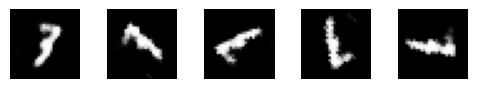

In [70]:
@torch.no_grad()
def generate_and_plot_samples(odeblock, decoder, latent_dim, time_steps, n_samples=4, device='cuda'):
    # Sample z0 ~ N(0, I)
    z0 = torch.randn(n_samples, latent_dim).to(device)
    
    # Integrate latent ODE (B, T, D)
    zt = odeblock(z0, time_steps)
    
    # Decode: (B, T, 1, 28, 28)
    x_recon = decoder(zt)

    # Plot each sequence
    fig, axes = plt.subplots(n_samples, len(time_steps), figsize=(len(time_steps), n_samples))
    if n_samples == 1:
        axes = axes[None, :]

    for i in range(n_samples):
        for j in range(len(time_steps)):
            axes[i, j].imshow(x_recon[i, j, 0].cpu(), cmap='gray')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

generate_and_plot_samples(odeblock, decoder, latent_dim, time_steps=time_steps, n_samples=1)